In [115]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import joblib
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('HealthCareData_2024.csv')
df.head()

,AlertCategory,NetworkEventType,NetworkInteractionType,DataTransferVolume_IN,DataTransferVolume_OUT,TransactionsPerSession,NetworkAccessFrequency,UserActivityLevel,SystemAccessRate,SessionIntegrityCheck,ResourceUtilizationFlag,SecurityRiskLevel,ResponseTime,Classification
0,Warning,Policy_Violation,Anomalous,131262728,146592187,32537,22456,5,NaN,True,False,132988661,31.62909,Normal
1,Warning,NormalOperation,Suspicious,129798635,146506072,33484,28572,6,NaN,False,False,143157300,32.46967,Normal
2,Warning,Policy_Violation,Elevated,126259145,220211406,47327,34350,6,NaN,False,False,119600509,28.10228,Normal
3,Warning,PolicyViolation,Suspicious,136336338,151520787,33754,29778,5,5.0,True,False,185064385,37.31185,Normal
4,Warning,PolicyViolation,Suspicious,135705149,164241334,35644,40153,5,NaN,True,False,163802278,99999.00000,Normal


In [3]:
df.shape

(568309, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568309 entries, 0 to 568308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   AlertCategory            568309 non-null  object 
 1   NetworkEventType         568309 non-null  object 
 2   NetworkInteractionType   568309 non-null  object 
 3   DataTransferVolume_IN    568309 non-null  int64  
 4   DataTransferVolume_OUT   568309 non-null  int64  
 5   TransactionsPerSession   568309 non-null  int64  
 6   NetworkAccessFrequency   568309 non-null  int64  
 7   UserActivityLevel        568309 non-null  int64  
 8   SystemAccessRate         227324 non-null  float64
 9   SessionIntegrityCheck    568309 non-null  bool   
 10  ResourceUtilizationFlag  568309 non-null  bool   
 11  SecurityRiskLevel        568309 non-null  int64  
 12  ResponseTime             568260 non-null  float64
 13  Classification           568309 non-null  object 
dtypes: b

In [5]:
# Identify categorical features (usually of dtype 'object')
categorical_features = df.select_dtypes(include=['object']).columns

# Initialize an empty list to store the table data
table_data = []

# Calculate missing values percentage for each category in each categorical feature
for feature in categorical_features:
    feature_data = df[feature].value_counts(dropna=False, normalize=True)
    for category, proportion in feature_data.items():
        if pd.isna(category):
            category = 'Missing'
        table_data.append([feature, category, f'{proportion * 100:.1f}%'])

# Create the table DataFrame
table_df = pd.DataFrame(table_data, columns=['name', 'category', 'missing values'])

# Display the table
print(table_df)

                      name          category missing values
0            AlertCategory           Warning          87.5%
1            AlertCategory     Informational           6.5%
2            AlertCategory             Alert           5.9%
3            AlertCategory              Info           0.1%
4         NetworkEventType   PolicyViolation          57.7%
5         NetworkEventType  Policy_Violation          30.0%
6         NetworkEventType   NormalOperation           8.1%
7         NetworkEventType    ThreatDetected           4.2%
8   NetworkInteractionType        Suspicious          45.1%
9   NetworkInteractionType         Anomalous          43.5%
10  NetworkInteractionType          Elevated           5.9%
11  NetworkInteractionType          Critical           5.3%
12  NetworkInteractionType           Regular           0.1%
13  NetworkInteractionType           Unknown           0.1%
14          Classification            Normal          96.0%
15          Classification         Malic

In [6]:
df['AlertCategory'] = df['AlertCategory'].replace('Info', 'Information')
df['NetworkEventType'] = df['NetworkEventType'].replace('Policy_Violation', 'PolicyViolation')

In [7]:
# Identify numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns

# Initialize an empty list to store the table data
table_data = []

# Calculate statistics for each numerical feature
for feature in numerical_features:
    missing_values = df[feature].isna().mean() * 100
    min_value = df[feature].min()
    max_value = df[feature].max()
    mean_value = df[feature].mean()
    std_dev = df[feature].std()
    median_value = df[feature].median()
    skewness_value = skew(df[feature].dropna())
    
    table_data.append([
        feature,
        f'{missing_values:.1f}%',
        min_value,
        max_value,
        mean_value,
        std_dev,
        median_value,
        skewness_value
    ])

# Create the table DataFrame
table_df = pd.DataFrame(table_data, columns=[
    'feature', 'missing values', 'min', 'max', 'mean', 'sd', 'median', 'skewness'
])

# Display the table
print(table_df)

                  feature missing values           min          max  \
0   DataTransferVolume_IN           0.0%  9.437211e+06  286793511.0   
1  DataTransferVolume_OUT           0.0%  1.024000e+03  300000000.0   
2  TransactionsPerSession           0.0%  1.024000e+03      65535.0   
3  NetworkAccessFrequency           0.0% -1.000000e+00      65535.0   
4       UserActivityLevel           0.0%  1.000000e+00         10.0   
5        SystemAccessRate          60.0%  0.000000e+00         10.0   
6       SecurityRiskLevel           0.0%  1.000000e+06  295330428.0   
7            ResponseTime           0.0%  2.310000e-03      99999.0   

           mean            sd        median  skewness  
0  1.321612e+08  1.298897e+07  1.308607e+08  1.860730  
1  1.428009e+08  3.447740e+07  1.435770e+08  0.003963  
2  3.247512e+04  6.769603e+03  3.226800e+04  0.136786  
3  3.198473e+04  9.975016e+03  3.321200e+04 -1.412986  
4  5.408874e+00  9.704544e-01  5.000000e+00  0.001445  
5  5.231766e+00  1.16977

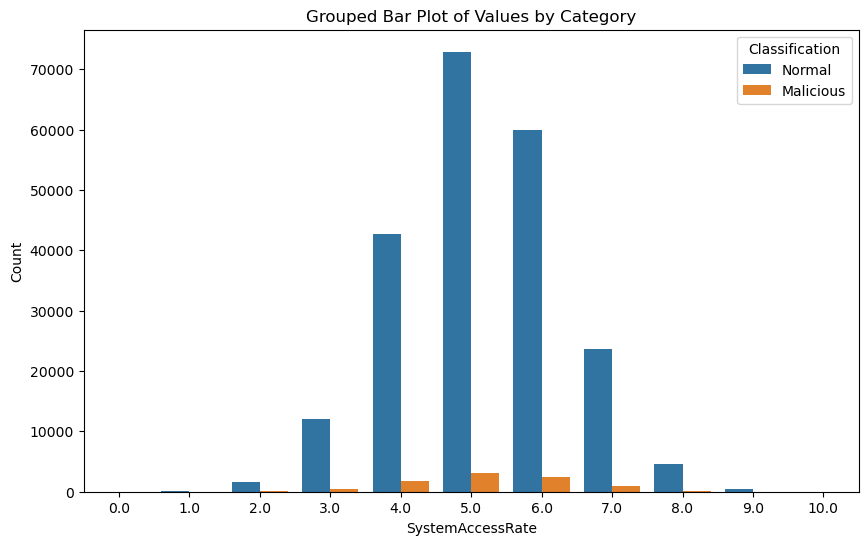

In [8]:
# Create the grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='SystemAccessRate', y='SystemAccessRate', hue='Classification', data=df, estimator=len, dodge=True)

# Add labels and title
plt.xlabel('SystemAccessRate')
plt.ylabel('Count')
plt.title('Grouped Bar Plot of Values by Category')
plt.legend(title='Classification')

# Display the plot
plt.show()

In [10]:
# Drop the 'SystemAccessRate' column
df.drop(columns=['SystemAccessRate'], inplace=True)

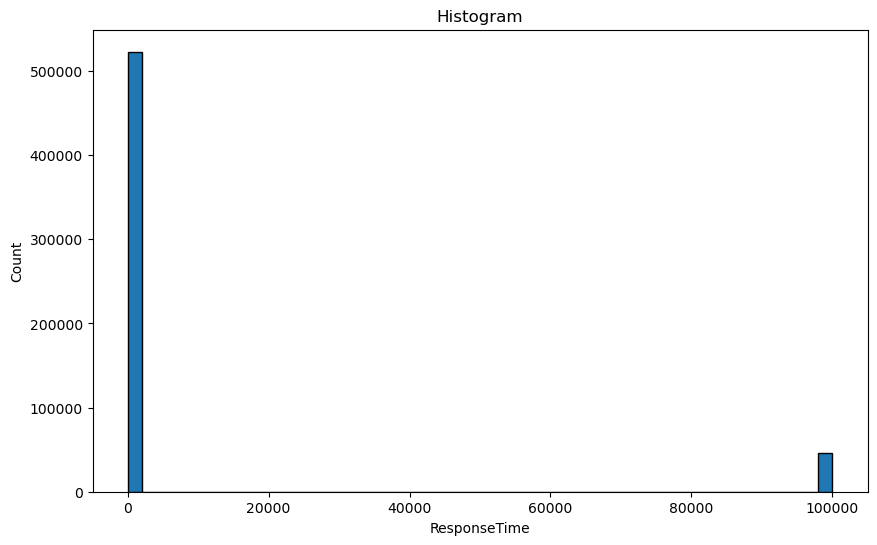

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(df['ResponseTime'], bins=50, edgecolor='black') 

# Add labels and title
plt.xlabel('ResponseTime')
plt.ylabel('Count')
plt.title('Histogram')

# Display the plot
plt.show()

In [12]:
df = df[df['ResponseTime'] != 99999]

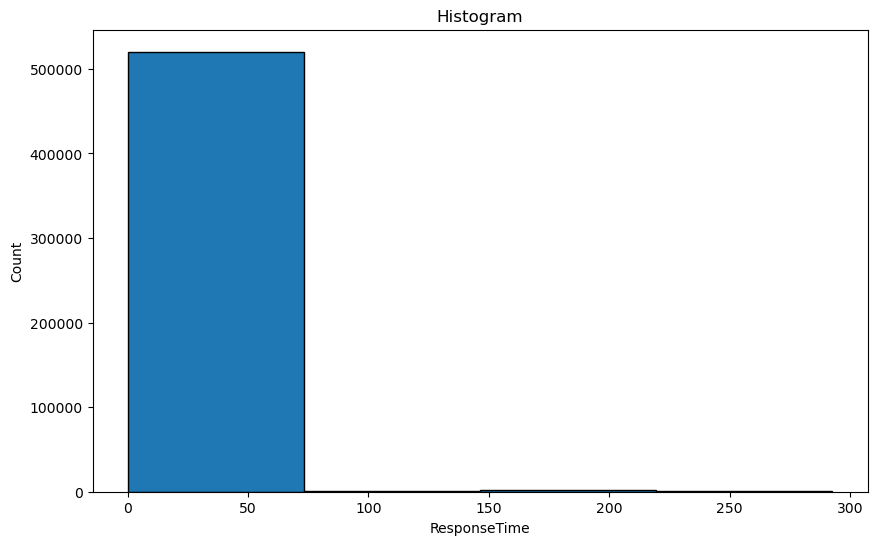

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df['ResponseTime'], bins=4, edgecolor='black')  # bins=4 for 4 bins

# Add labels and title
plt.xlabel('ResponseTime')
plt.ylabel('Count')
plt.title('Histogram')

# Display the plot
plt.show()

In [14]:
df = df[df['ResponseTime'] < 150]

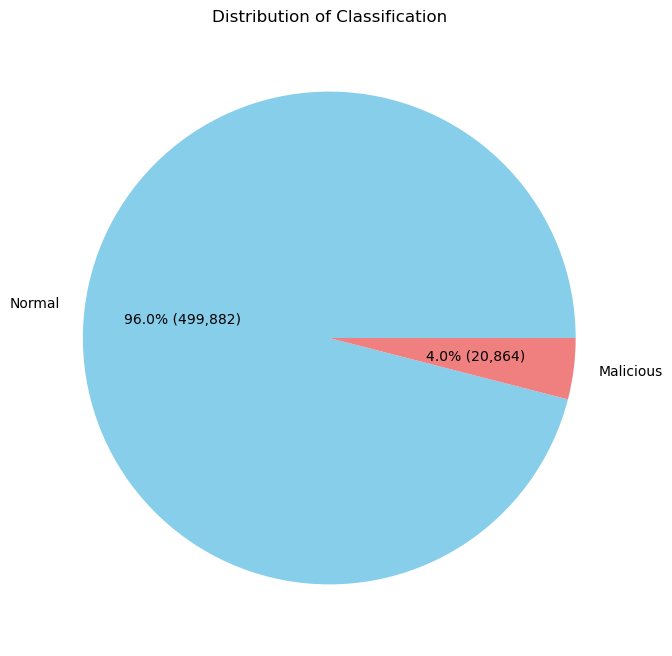

In [15]:
# Count the values in the 'Classification' column
classification_counts = df['Classification'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(classification_counts, labels=classification_counts.index, autopct=lambda p: '{:.1f}% ({:,.0f})'.format(p, p * sum(classification_counts) / 100), colors=['skyblue', 'lightcoral'])

# Add a title
plt.title('Distribution of Classification')

# Display the plot
plt.show()

In [16]:
# Map 'Normal' to 0 and 'Malicious' to 1
df['Classification'] = df['Classification'].map({'Normal': 0, 'Malicious': 1})

In [17]:
# Split the DataFrame into features and target
X = df.drop('Classification', axis=1)
y = df['Classification']

In [18]:
# Apply SMOTE to the training set
smote = SMOTENC(categorical_features=[0, 1, 2, 8, 9], random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

<Axes: ylabel='Classification'>

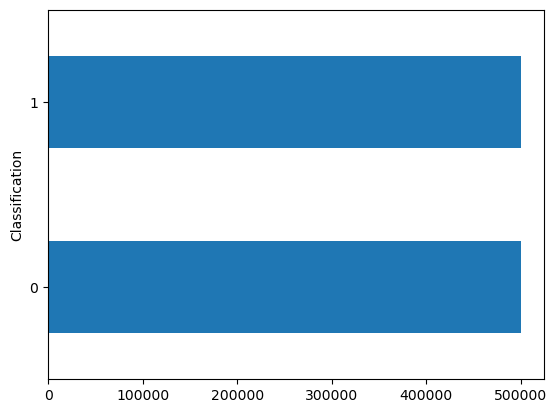

In [20]:
# Count the values in the resampled target
classification_counts = pd.Series(y_resampled).value_counts()

classification_counts.plot(kind = 'barh')

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [24]:
# Define the numerical and categorical features
numerical_features = ['DataTransferVolume_IN', 'DataTransferVolume_OUT',
                      'TransactionsPerSession','NetworkAccessFrequency',
                      'UserActivityLevel','SecurityRiskLevel','ResponseTime']

categorical_features = ['AlertCategory','NetworkEventType',
                        'NetworkInteractionType','SessionIntegrityCheck',
                        'ResourceUtilizationFlag']

In [26]:
# Create preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('label_encoder', OrdinalEncoder())
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [27]:
# Define the models with their respective parameter grids for tuning
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'classifier__learning_rate': [0.1, 0.01],
            'classifier__max_depth': [3, 5],
            'classifier__min_child_weight': [1, 3]
        }
    },
    'Neural Network': {
        'model': MLPClassifier(max_iter=1000),
        'params': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'classifier__activation': ['relu', 'tanh'],
            'classifier__alpha': [0.0001, 0.001, 0.01]
        }
    }
}

# Dictionary to hold the best estimator and score for each model
best_estimators = {}

# Perform GridSearchCV for each model
for name, model_info in models.items():
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_info['model'])
    ])
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Store the best estimator and best score
    best_estimators[name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_score': grid_search.best_score_
    }
    
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Best accuracy for {name}: {grid_search.best_score_:.4f}')
    print()

# Evaluate on test set (optional)
print("\nEvaluation on Test Set:")
for name, estimator_info in best_estimators.items():
    joblib.dump(estimator_info['best_estimator'], f'{name}_best_model_SMOTE.pkl')
    test_score = estimator_info['best_estimator'].score(X_test, y_test)
    print(f'{name} Test Accuracy: {test_score:.4f}') 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best accuracy for Logistic Regression: 0.9074

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1}
Best accuracy for XGBoost: 0.9373

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for Neural Network: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50)}
Best accuracy for Neural Network: 0.9452


Evaluation on Test Set:
Logistic Regression Test Accuracy: 0.9063
XGBoost Test Accuracy: 0.9368
Neural Network Test Accuracy: 0.9444


In [29]:
# Load the models
model1 = joblib.load('Logistic Regression_best_model_SMOTE.pkl')
model2 = joblib.load('XGBoost_best_model_SMOTE.pkl')  
model3 = joblib.load('Neural Network_best_model_SMOTE.pkl')

In [31]:
# X_test and y_test are already defined
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

# Calculate metrics
metrics_SMOTE_1 = {
    'Accuracy': accuracy_score(y_test, y_pred1),
    'Precision': precision_score(y_test, y_pred1, average='weighted'),
    'Recall': recall_score(y_test, y_pred1, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred1, average='weighted')
}

metrics_SMOTE_2 = {
    'Accuracy': accuracy_score(y_test, y_pred2),
    'Precision': precision_score(y_test, y_pred2, average='weighted'),
    'Recall': recall_score(y_test, y_pred2, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred2, average='weighted')
}

metrics_SMOTE_3 = {
    'Accuracy': accuracy_score(y_test, y_pred3),
    'Precision': precision_score(y_test, y_pred3, average='weighted'),
    'Recall': recall_score(y_test, y_pred3, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred3, average='weighted')
}

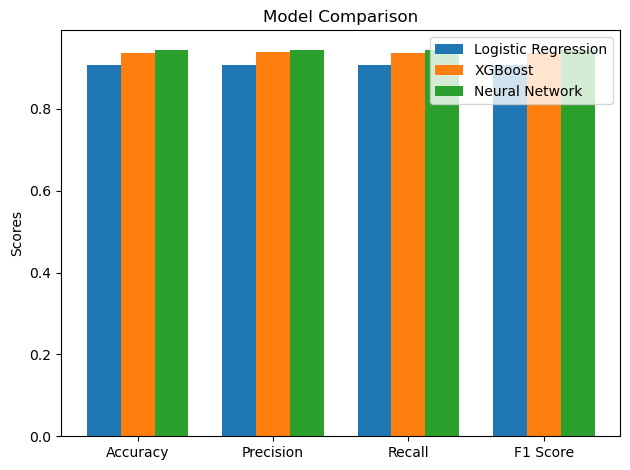

In [32]:
# Prepare data for plotting
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics = [metrics_SMOTE_1, metrics_SMOTE_2, metrics_SMOTE_3]
model_names = ['Logistic Regression', 'XGBoost', 'Neural Network']

data = np.array([[m[metric] for metric in labels] for m in metrics])

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, data[0], width, label='Logistic Regression')
rects2 = ax.bar(x, data[1], width, label='XGBoost')
rects3 = ax.bar(x + width, data[2], width, label='Neural Network')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

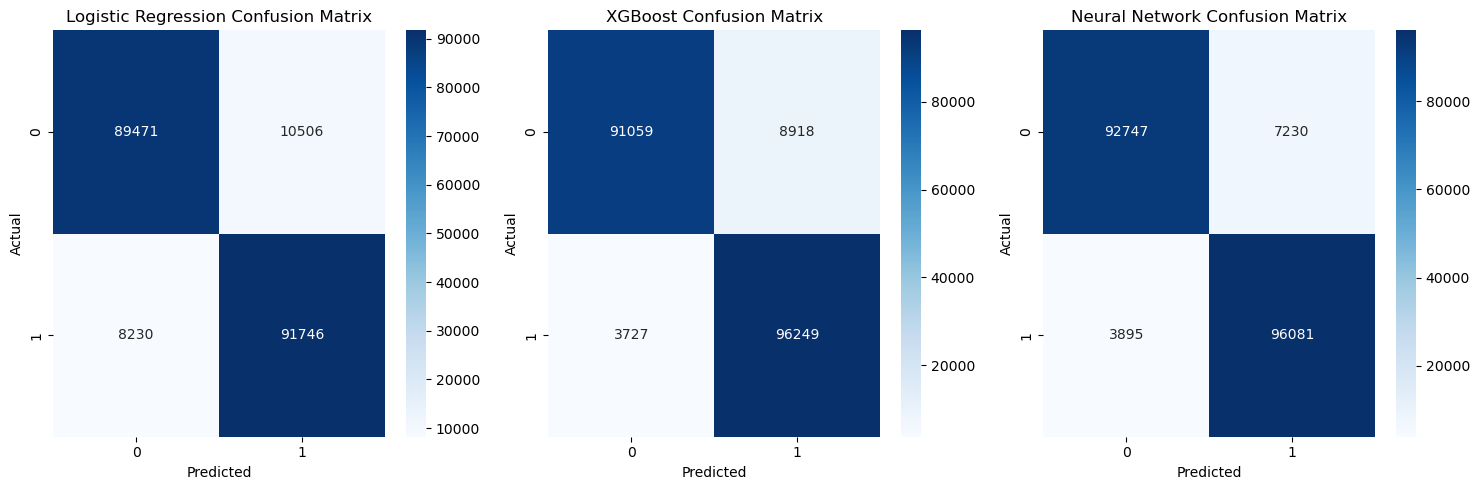

In [33]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (y_pred, title) in enumerate(zip([y_pred1, y_pred2, y_pred3], model_names)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{title} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [34]:
# Apply undersampling to the training set
undersample = RandomUnderSampler(sampling_strategy='auto')
X_under, y_under = undersample.fit_resample(X, y)

<Axes: ylabel='Classification'>

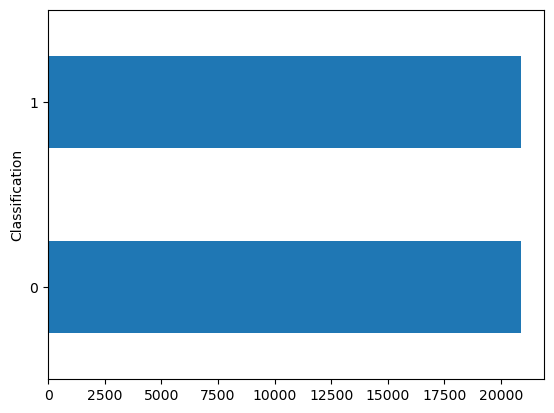

In [35]:
# Count the values in the under sampled target
classification_counts = pd.Series(y_under).value_counts()

classification_counts.plot(kind = 'barh')

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42, stratify=y_under)

In [37]:
# Define the models with their respective parameter grids for tuning
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'classifier__learning_rate': [0.1, 0.01],
            'classifier__max_depth': [3, 5],
            'classifier__min_child_weight': [1, 3]
        }
    },
    'Neural Network': {
        'model': MLPClassifier(),
        'params': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'classifier__activation': ['relu', 'tanh'],
            'classifier__alpha': [0.0001, 0.001, 0.01]
        }
    }
}

# Dictionary to hold the best estimator and score for each model
best_estimators = {}

# Perform GridSearchCV for each model
for name, model_info in models.items():
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_info['model'])
    ])
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Store the best estimator and best score
    best_estimators[name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_score': grid_search.best_score_
    }
    
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Best accuracy for {name}: {grid_search.best_score_:.4f}')
    print()

# Evaluate on test set (optional)
print("\nEvaluation on Test Set:")
for name, estimator_info in best_estimators.items():
    joblib.dump(estimator_info['best_estimator'], f'{name}_best_model_UNDER.pkl')
    test_score = estimator_info['best_estimator'].score(X_test, y_test)
    print(f'{name} Test Accuracy: {test_score:.4f}') 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Logistic Regression: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best accuracy for Logistic Regression: 0.8803

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 3}
Best accuracy for XGBoost: 0.9179

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Best parameters for Neural Network: {'classifier__activation': 'tanh', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50,)}
Best accuracy for Neural Network: 0.9230


Evaluation on Test Set:
Logistic Regression Test Accuracy: 0.8795
XGBoost Test Accuracy: 0.9216
Neural Network Test Accuracy: 0.9250


In [40]:
# Load the models
model1 = joblib.load('Logistic Regression_best_model_UNDER.pkl')
model2 = joblib.load('XGBoost_best_model_UNDER.pkl')  
model3 = joblib.load('Neural Network_best_model_UNDER.pkl')

In [45]:
# X_test and y_test are already defined
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

# Calculate metrics
metrics_UNDER_1 = {
    'Accuracy': accuracy_score(y_test, y_pred1),
    'Precision': precision_score(y_test, y_pred1, average='weighted'),
    'Recall': recall_score(y_test, y_pred1, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred1, average='weighted')
}

metrics_UNDER_2 = {
    'Accuracy': accuracy_score(y_test, y_pred2),
    'Precision': precision_score(y_test, y_pred2, average='weighted'),
    'Recall': recall_score(y_test, y_pred2, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred2, average='weighted')
}

metrics_UNDER_3 = {
    'Accuracy': accuracy_score(y_test, y_pred3),
    'Precision': precision_score(y_test, y_pred3, average='weighted'),
    'Recall': recall_score(y_test, y_pred3, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred3, average='weighted')
}

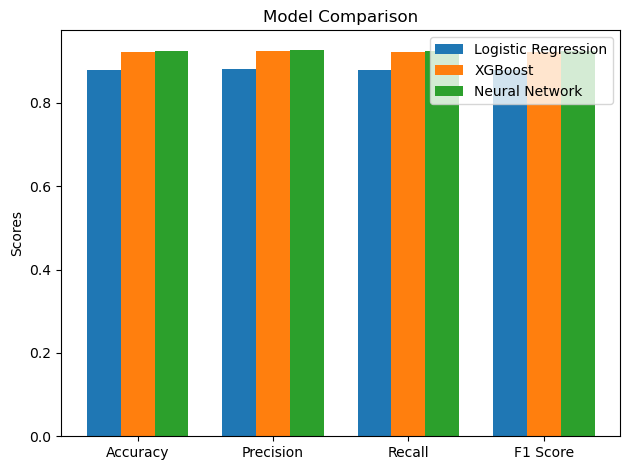

In [49]:
# Prepare data for plotting
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics = [metrics_UNDER_1, metrics_UNDER_2, metrics_UNDER_3]
model_names = ['Logistic Regression', 'XGBoost', 'Neural Network']

data = np.array([[m[metric] for metric in labels] for m in metrics])

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, data[0], width, label='Logistic Regression')
rects2 = ax.bar(x, data[1], width, label='XGBoost')
rects3 = ax.bar(x + width, data[2], width, label='Neural Network')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

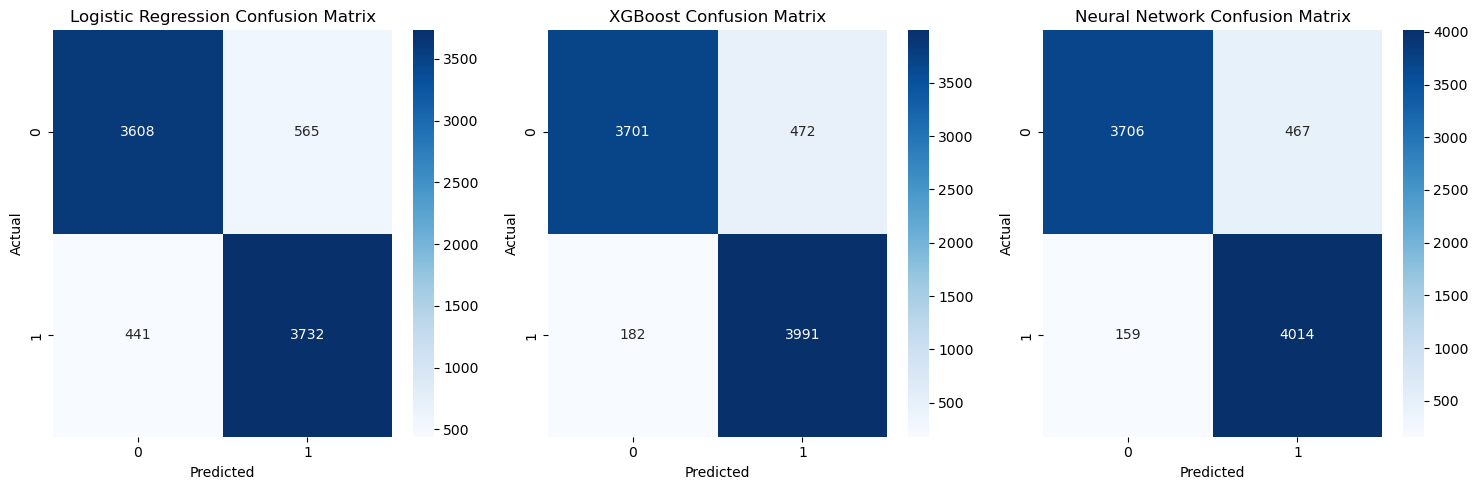

In [50]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (y_pred, title) in enumerate(zip([y_pred1, y_pred2, y_pred3], model_names)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{title} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [113]:
# Define the table headers
headers = ["", "Undersampling ", "", 
           "", "", 
           "Oversampling (SMOTE-NC)", "", 
           "", ""]

table = [
    ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 
     'Accuracy', 'Precision', 'Recall', 'F1 Score'],
    
    ["Logistic Regression",
     round(metrics_UNDER_1['Accuracy'], 4),
     round(metrics_UNDER_1['Precision'], 4),
     round(metrics_UNDER_1['Recall'], 4),
     round(metrics_UNDER_1['F1 Score'], 4),
     round(metrics_SMOTE_1['Accuracy'], 4),
     round(metrics_SMOTE_1['Precision'], 4),
     round(metrics_SMOTE_1['Recall'], 4),
     round(metrics_SMOTE_1['F1 Score'], 4)],
    
    ["XGBoost",
     round(metrics_UNDER_2['Accuracy'], 4),
     round(metrics_UNDER_2['Precision'], 4),
     round(metrics_UNDER_2['Recall'], 4),
     round(metrics_UNDER_2['F1 Score'], 4),
     round(metrics_SMOTE_2['Accuracy'], 4),
     round(metrics_SMOTE_2['Precision'], 4),
     round(metrics_SMOTE_2['Recall'], 4),
     round(metrics_SMOTE_2['F1 Score'], 4)],
    
    ["Neural Network",
     round(metrics_UNDER_3['Accuracy'], 4),
     round(metrics_UNDER_3['Precision'], 4),
     round(metrics_UNDER_3['Recall'], 4),
     round(metrics_UNDER_3['F1 Score'], 4),
     round(metrics_SMOTE_3['Accuracy'], 4),
     round(metrics_SMOTE_3['Precision'], 4),
     round(metrics_SMOTE_3['Recall'], 4),
     round(metrics_SMOTE_3['F1 Score'], 4)]
]


# Print the HTML table
html_table = tabulate(table, headers=headers, tablefmt='html')
html_table

,Undersampling,,,,Oversampling (SMOTE-NC),,,
Model,Accuracy,Precision,Recall,F1 Score,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.8795,0.8798,0.8795,0.8794,0.9063,0.9065,0.9063,0.9063
XGBoost,0.9216,0.9237,0.9216,0.9215,0.9368,0.9379,0.9368,0.9367
Neural Network,0.925,0.9273,0.925,0.9249,0.9444,0.9449,0.9444,0.9443
